# Scene Segmentation Experiment for ADE20K

This notebook will investigate training the Proglearn classification forest on scene segmentation using the ADE20K dataset, http://groups.csail.mit.edu/vision/datasets/ADE20K/


**Import packages**

In [3]:
import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt

# Loading Data

The following is code taken from Narayani Wagle to pre-process and flatten the images.

In [4]:
# (OPTIONAL) RUN THIS CELL TO UNZIP DATA FROM SITE

# CHANGE PATH TO WHERE YOU HAVE YOUR ZIP FILE LOCATED
path_to_zipfile = 'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency.zip'

# don't change this
directory_to_extract_to = './'
with zipfile.ZipFile(path_to_zipfile, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [5]:
# RUN THIS CELL TO LOAD DATA AND SORT INTO SAMPLES AND LABELS

# CHANGE PATH TO ROOT DIRECTORY OF WHERE YOUR DATA IS LOCATED
# e.g. ./projects/
dataloc = 'C:/Users/Amy/Documents/Python/Neuro Data Design/'

# don't change this
datadir = dataloc + 'ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/'
imgkeys = [im.split('_seg')[0] for im in os.listdir(datadir) if '_seg' in im]
lblpaths = [datadir+im for im in os.listdir(datadir) if '_seg' in im]
imgpaths = [datadir+im for im in os.listdir(datadir) if '.jpg' in im and im.split('.jpg')[0] in imgkeys]


imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))
imgpaths[:5], lblpaths[:5]

Total # of images = 64
Total # of labels = 64


(['C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001034.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001054.jpg'],
 ['C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001_seg.png',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/origi

In [6]:
def load_images(flatten_imgs):
    if flatten_imgs:
        X = np.array([cv2.imread(imgpath).flatten() for imgpath in imgpaths])
        Y = np.array([cv2.imread(lblpath).flatten() for lblpath in lblpaths])
    else:
        X = np.array([cv2.imread(imgpath) for imgpath in imgpaths])
        Y = np.array([cv2.imread(lblpath) for lblpath in lblpaths])
    return X,Y

In [7]:
# change flatten_imgs to True or False depending on how you want to load the data
flatten_imgs = True
flat_x, flat_y = load_images(flatten_imgs)
print(flat_x.shape, flat_x[0], flat_x[0].shape)

C:\Users\Amy\AppData\Local\Temp/ipykernel_160408/1677122020.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array([cv2.imread(imgpath).flatten() for imgpath in imgpaths])


(64,) [251 251 251 ... 119 102 111] (10890000,)


C:\Users\Amy\AppData\Local\Temp/ipykernel_160408/1677122020.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Y = np.array([cv2.imread(lblpath).flatten() for lblpath in lblpaths])


This marks the end of Narayani's code

In [8]:
# change flatten_imgs to True or False depending on how you want to load the data
flatten_imgs = False
data_x, data_y = load_images(flatten_imgs)
print(data_x.shape, data_x[0].shape)

C:\Users\Amy\AppData\Local\Temp/ipykernel_160408/1677122020.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array([cv2.imread(imgpath) for imgpath in imgpaths])


(64,) (2200, 1650, 3)


C:\Users\Amy\AppData\Local\Temp/ipykernel_160408/1677122020.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Y = np.array([cv2.imread(lblpath) for lblpath in lblpaths])


# Testing other methods of image segmentation: Scikit Skimage

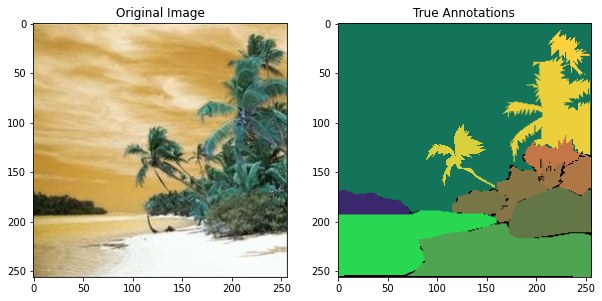

In [9]:
# Image 10/64 (palm tree + beach)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

image = cv2.imread(imgpaths[9])
label = cv2.imread(lblpaths[9]) 
ax[0].imshow(image)
ax[0].set_title("Original Image")

ax[1].imshow(label)
ax[1].set_title("True Annotations")
plt.show()

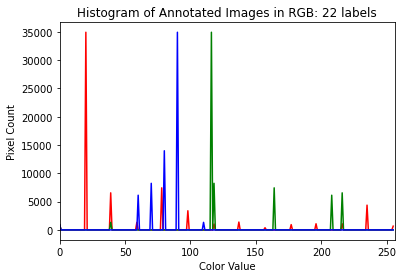

In [10]:
# show histogram of image

# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        label[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color Value")
plt.ylabel("Pixel Count")
plt.title("Histogram of Annotated Images in RGB: %d labels" %(np.unique(label).size))

plt.show()

## Testing with Greyscale

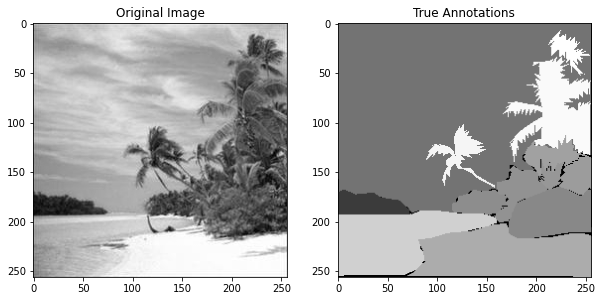

In [12]:
# convert to greyscale

from skimage.color import rgb2gray

image_grey = rgb2gray(image)
label_grey = rgb2gray(label)
label_grey = label_grey * 1000
label_grey = label_grey.astype(int)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

ax[0].imshow(image_grey, cmap = plt.cm.gray)
ax[0].set_title("Original Image")

ax[1].imshow(label_grey, cmap = plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

Text(0, 0.5, 'Pixel Count')

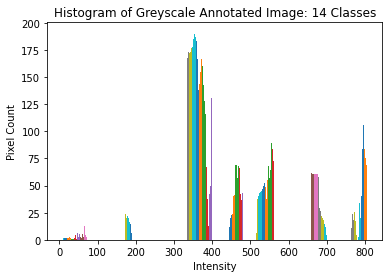

In [13]:
# plot histogram of greyscale

plt.hist(label_grey)
plt.title("Histogram of Greyscale Annotated Image: %d Classes" %(np.unique(label_grey).size))
plt.xlabel("Intensity")
plt.ylabel("Pixel Count")

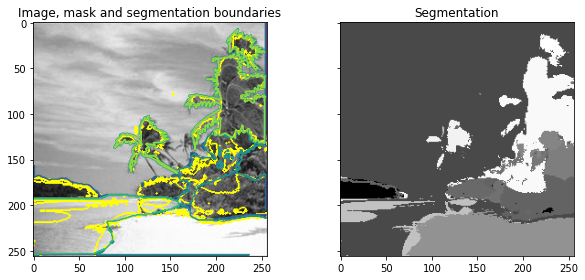

In [14]:
# perform segmentation 

import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import cv2

img = image_grey
training_labels = label_grey

#img = cv2.cvtColor(image[:2000, :1500]) # make dimensions line up
#training_labels = cv2.cvtColor(data_y[9])

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap = plt.cm.gray)
ax[1].set_title('Segmentation')
fig.tight_layout()

## Analyzing Accuracy

In [ ]:
# dice score
def get_dice(true, test):
    return np.size(test[test == true]) * 2.0 / (np.size(true) + np.size(test))

Adapted Rand error: 0.18436319144096858
Adapted Rand precision: 0.9446954522231865
Adapted Rand recall: 0.7176022765946168
False Splits: 0.5225360219692305
False Merges: 0.9859921224211139


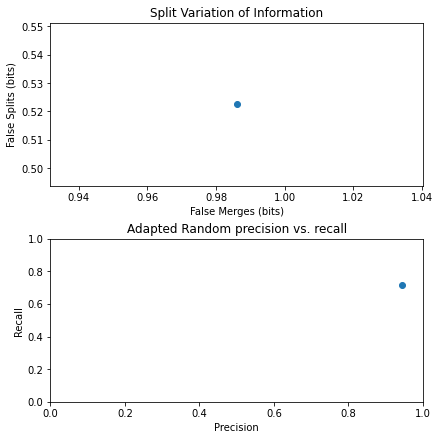

0.8289947509765625

In [17]:
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

error, precision, recall = adapted_rand_error(label_grey, result)
splits, merges = variation_of_information(label_grey, result)
print(f'Adapted Rand error: {error}')
print(f'Adapted Rand precision: {precision}')
print(f'Adapted Rand recall: {recall}')
print(f'False Splits: {splits}')
print(f'False Merges: {merges}')

fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merges, splits)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision, recall)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

plt.show()

get_dice(label_grey, result)

# Perform Skimage segmentation on all 64 images

In [18]:
# make array of greyscale
images_grey = np.array([rgb2gray(cv2.imread(imgpath)) for imgpath in imgpaths])
labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])

# image not always same shape as labels
# identify images with matching dimensions between image and label
images_grey_match = images_grey[[images_grey[i].shape == labels_grey[i].shape for i in np.arange(len(images_grey))]]
labels_grey_match = labels_grey[[images_grey[i].shape == labels_grey[i].shape for i in np.arange(len(images_grey))]]

C:\Users\Amy\AppData\Local\Temp/ipykernel_160408/231159144.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  images_grey = np.array([rgb2gray(cv2.imread(imgpath)) for imgpath in imgpaths])
C:\Users\Amy\AppData\Local\Temp/ipykernel_160408/231159144.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])


In [80]:
# initialize arrays
error_list = np.zeros(len(images_grey_match))
precision_list = np.zeros(len(images_grey_match))
recall_list = np.zeros(len(images_grey_match))
splits_list = np.zeros(len(images_grey_match))
merges_list = np.zeros(len(images_grey_match))
dice_list = np.zeros(len(images_grey_match))
result_list = np.zeros(len(images_grey_match), dtype = object)

# loop through each image and determine values
for i in np.arange(len(images_grey_match)):
    # use classifier
    features = features_func(images_grey_match[i])
    result = future.predict_segmenter(features, clf)

    # assess
    error, precision, recall = adapted_rand_error(labels_grey_match[i], result)
    splits, merges = variation_of_information(labels_grey_match[i], result)
    dice = get_dice(labels_grey_match[i], result)

    # add to list
    error_list[i] = error
    precision_list[i] = precision
    recall_list[i] = recall
    splits_list[i] = splits
    merges_list[i] = merges
    dice_list[i] = dice
    result_list[i] = result

# takes 4 min 15.7s to run

Text(0.5, 1.0, 'Histogram of Dice Coefficients')

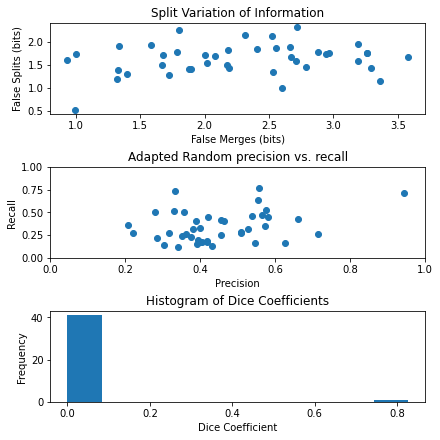

In [71]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merges_list, splits_list)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision_list, recall_list)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

ax[2].hist(dice_list)
ax[2].set_xlabel('Dice Coefficient')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Histogram of Dice Coefficients')

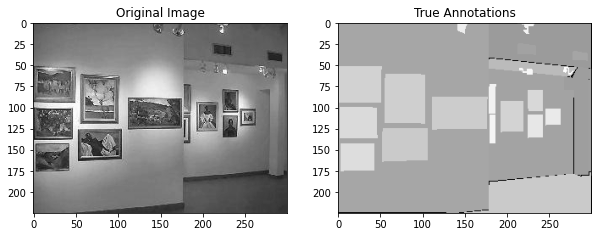

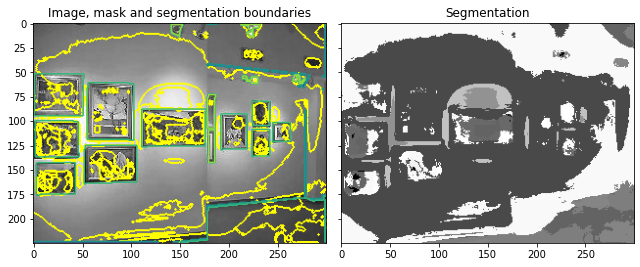

In [84]:
# see low accuracy since had only trained on one image which has high dice coefficient

# original
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

ax[0].imshow(images_grey_match[1], cmap = plt.cm.gray)
ax[0].set_title("Original Image")

ax[1].imshow(labels_grey_match[1], cmap = plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

# segmented
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(images_grey_match[1], result_list[1], mode='thick'))
ax[0].contour(labels_grey_match[1])
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result_list[1], cmap = plt.cm.gray)
ax[1].set_title('Segmentation')
fig.tight_layout()

# Updates to Skimage Segmentation Analysis

In [41]:
# identify images with matching dimensions between image and label
images_grey_match = images_grey[[images_grey[i].shape == labels_grey[i].shape for i in np.arange(len(images_grey))]]
labels_grey_match = labels_grey[[images_grey[i].shape == labels_grey[i].shape for i in np.arange(len(images_grey))]]

labels_grey_match.shape

(42,)

In [46]:
train_images = images_grey_match[0:30]

(30,)

In [42]:
# train on 80% of data

train_images = images_grey_match[0:30]
train_labels = labels_grey_match[0:30]

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(train_images)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(train_labels, features, clf)

ValueError: Can not convert from object to float32.

# Proglearn

In [19]:
from proglearn import LifelongClassificationForest

In [20]:
# set up
progtree = LifelongClassificationForest()
progtree.add_task(images_grey_match[9], labels_grey_match[9])

# test
prediction = progtree.predict(images_grey_match[10], task_id = 0)
prediction_proba = progtree.predict_proba(images_grey_match[10], task_id = 0)

ValueError: y should be a 1d array, got an array of shape (1200, 1600) instead.

# Analyzing Proglearn

**Analyze Results**
- accuracy (ACC)
- forwards transfer efficiency (FTE)
- backwards transfer efficiency (BTE)
- overall transfer efficiency (TE)